# Baseline Results for Multi-modal Approaches

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from pathlib import Path
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM2D
from tensorflow.keras import models

warnings.filterwarnings("ignore")

In [2]:
accuracies = []
aucs = []
model_names = ['M1.1 CNN+LSTM', 'M1.1 ConvLSTM', 'M1.2 CNN+LSTM', 'M1.2 ConvLSTM']

In [3]:
def load_file(file, prediction_type):
    df = pd.read_csv(file, header=0)
    labels = df[prediction_type]
    df = df.drop(columns=['pain_area', 'pain_level'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df.to_numpy(), labels

def reshape_CNN_data(X, n_length, n_features):
    return X.reshape((len(X), 1, n_length, n_features))

def reshape_LSTM_data(X, n_length, n_features):
    return X.reshape((len(X), 1, 1, n_length, n_features))

def load_dataset(input_filepath, prediction_type, modality, architecture):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_train = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_train = reshape_LSTM_data(X, n_length, n_features)
    y_train = pd.get_dummies(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_test = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_test = reshape_LSTM_data(X, n_length, n_features)
    y_test = pd.get_dummies(y)
    y_test, tmp = y_test.align(y_train, join='outer', axis=1, fill_value=0)
    return X_train, X_test, y_train, y_test

## 1. Model-free Fusion

Two variants:

- **Early fusion**: concatenates features at the input level, then all the work is on the classifier. My initial assumption is that perhaps early fusion is not a good idea because face modality is missing about half the times?

- **Late fusion**: "pre-training", train one classifier per modality independently (with the same output label as the label at the end). Late fusion mechanism can be voting (majority or weighted) or weighted sum to aggregate predictions at the decision level. 

### 1.1 Early Fusion - Pain area prediction

#### Concatenate datasets (fusion stage)

In [4]:
def apply_early_fusion(input_filepath, prediction_type, architecture):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_train = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_train = reshape_LSTM_data(X, n_length, n_features)
    y_train = pd.get_dummies(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file, prediction_type)
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file, prediction_type)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                # Add null values to the face features
                full_X = np.concatenate((body_x, np.zeros((body_x.shape[0], 10))), axis=1)
                X.append(full_X)
                y.append(body_labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_test = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_test = reshape_LSTM_data(X, n_length, n_features)
    y_test = pd.get_dummies(y)
    y_test, tmp = y_test.align(y_train, join='outer', axis=1, fill_value=0)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_area', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 5)
(81, 1, 350, 48) (81, 5)


#### Train CNN+LSTM Model (from uni-modal architectures)

In [6]:
epochs, batch_size = 50, 68
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [7]:
def get_CNN_model(n_features, n_outputs, n_length):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [8]:
early_fusion_model = get_CNN_model(n_features, n_outputs, n_length)
early_fusion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 348, 64)    9280      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 348, 32)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 11136)      0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               4494800   
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                        

Epoch 1/50
6/6 - 2s - loss: 1.5288 - accuracy: 0.3736 - auc_1: 0.6224 - val_loss: 1.3529 - val_accuracy: 0.5337 - val_auc_1: 0.7872 - 2s/epoch - 375ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3042 - accuracy: 0.5702 - auc_1: 0.7971 - val_loss: 1.3005 - val_accuracy: 0.5337 - val_auc_1: 0.7943 - 327ms/epoch - 55ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2783 - accuracy: 0.5702 - auc_1: 0.7953 - val_loss: 1.2601 - val_accuracy: 0.5337 - val_auc_1: 0.7941 - 330ms/epoch - 55ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2315 - accuracy: 0.5702 - auc_1: 0.7999 - val_loss: 1.2348 - val_accuracy: 0.5337 - val_auc_1: 0.7940 - 332ms/epoch - 55ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2098 - accuracy: 0.5702 - auc_1: 0.7973 - val_loss: 1.2287 - val_accuracy: 0.5337 - val_auc_1: 0.7905 - 333ms/epoch - 55ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2007 - accuracy: 0.5702 - auc_1: 0.7969 - val_loss: 1.2254 - val_accuracy: 0.5337 - val_auc_1: 0.7905 - 337ms/epoch - 56ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1965 - accuracy: 0.5702 

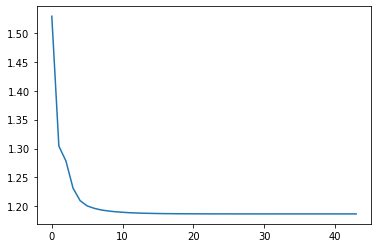

Epoch 1/50
6/6 - 2s - loss: 1.4227 - accuracy: 0.4916 - auc_2: 0.6955 - val_loss: 1.2722 - val_accuracy: 0.5787 - val_auc_2: 0.8103 - 2s/epoch - 390ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3053 - accuracy: 0.5478 - auc_2: 0.7784 - val_loss: 1.2470 - val_accuracy: 0.5787 - val_auc_2: 0.7781 - 327ms/epoch - 55ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2709 - accuracy: 0.5478 - auc_2: 0.7895 - val_loss: 1.2174 - val_accuracy: 0.5787 - val_auc_2: 0.8090 - 321ms/epoch - 54ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2455 - accuracy: 0.5478 - auc_2: 0.7991 - val_loss: 1.2015 - val_accuracy: 0.5787 - val_auc_2: 0.8090 - 323ms/epoch - 54ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2307 - accuracy: 0.5478 - auc_2: 0.8007 - val_loss: 1.1926 - val_accuracy: 0.5787 - val_auc_2: 0.8090 - 331ms/epoch - 55ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2206 - accuracy: 0.5478 - auc_2: 0.8005 - val_loss: 1.1871 - val_accuracy: 0.5787 - val_auc_2: 0.8090 - 333ms/epoch - 56ms/step
Epoch 7/50
6/6 - 0s - loss: 1.2154 - accuracy: 0.5478 

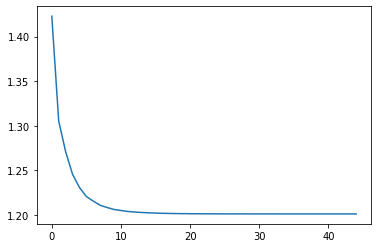

Epoch 1/50
6/6 - 2s - loss: 1.4477 - accuracy: 0.5000 - auc_3: 0.7032 - val_loss: 1.3034 - val_accuracy: 0.5618 - val_auc_3: 0.7669 - 2s/epoch - 365ms/step
Epoch 2/50
6/6 - 0s - loss: 1.3019 - accuracy: 0.5562 - auc_3: 0.7643 - val_loss: 1.2434 - val_accuracy: 0.5618 - val_auc_3: 0.7851 - 335ms/epoch - 56ms/step
Epoch 3/50
6/6 - 0s - loss: 1.2488 - accuracy: 0.5562 - auc_3: 0.7795 - val_loss: 1.2193 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 337ms/epoch - 56ms/step
Epoch 4/50
6/6 - 0s - loss: 1.2203 - accuracy: 0.5562 - auc_3: 0.8029 - val_loss: 1.2067 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 337ms/epoch - 56ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2047 - accuracy: 0.5562 - auc_3: 0.8020 - val_loss: 1.1997 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 338ms/epoch - 56ms/step
Epoch 6/50
6/6 - 0s - loss: 1.1950 - accuracy: 0.5562 - auc_3: 0.8049 - val_loss: 1.1966 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 338ms/epoch - 56ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1899 - accuracy: 0.5562 

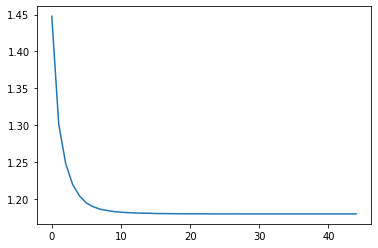

In [9]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    early_fusion_model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Evaluate early fusion performance

In [10]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.7994


#### Train Convolutional LSTM Model (from uni-modal architectures)

In [11]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_area', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 1, 350, 48) (534, 5)
(81, 1, 1, 350, 48) (81, 5)


In [12]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [13]:
def get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length):
    model = models.Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(
        1, 3), activation='relu', input_shape=(n_timesteps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [14]:
early_fusion_model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
early_fusion_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 348, 64)        86272     
                                                                 
 flatten_4 (Flatten)         (None, 22272)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               2227300   
                                                                 
 dense_9 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,314,077
Trainable params: 2,314,077
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 - 3s - loss: 175.3226 - accuracy: 0.3202 - auc_5: 0.5770 - val_loss: 45.9103 - val_accuracy: 0.5337 - val_auc_5: 0.7086 - 3s/epoch - 459ms/step
Epoch 2/50
6/6 - 1s - loss: 24.0171 - accuracy: 0.4494 - auc_5: 0.7283 - val_loss: 7.4835 - val_accuracy: 0.5000 - val_auc_5: 0.7254 - 861ms/epoch - 143ms/step
Epoch 3/50
6/6 - 1s - loss: 3.8084 - accuracy: 0.4579 - auc_5: 0.7260 - val_loss: 1.9302 - val_accuracy: 0.1966 - val_auc_5: 0.5519 - 863ms/epoch - 144ms/step
Epoch 4/50
6/6 - 1s - loss: 1.6563 - accuracy: 0.1348 - auc_5: 0.5730 - val_loss: 1.6118 - val_accuracy: 0.0393 - val_auc_5: 0.5159 - 870ms/epoch - 145ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5726 - accuracy: 0.2500 - auc_5: 0.5401 - val_loss: 1.5979 - val_accuracy: 0.5281 - val_auc_5: 0.5152 - 860ms/epoch - 143ms/step
Epoch 6/50
6/6 - 1s - loss: 1.5801 - accuracy: 0.5730 - auc_5: 0.6142 - val_loss: 1.5940 - val_accuracy: 0.5337 - val_auc_5: 0.7076 - 859ms/epoch - 143ms/step
Epoch 7/50
6/6 - 1s - loss: 1.5812 - accuracy

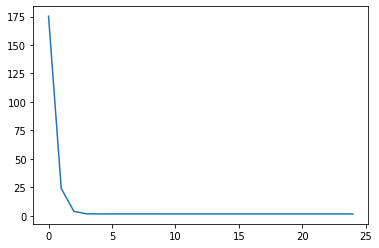

Epoch 1/50
6/6 - 3s - loss: 90.4489 - accuracy: 0.3174 - auc_6: 0.5702 - val_loss: 59.3658 - val_accuracy: 0.0955 - val_auc_6: 0.4551 - 3s/epoch - 517ms/step
Epoch 2/50
6/6 - 1s - loss: 23.2958 - accuracy: 0.3483 - auc_6: 0.6169 - val_loss: 1.6449 - val_accuracy: 0.2022 - val_auc_6: 0.5912 - 843ms/epoch - 140ms/step
Epoch 3/50
6/6 - 1s - loss: 1.6349 - accuracy: 0.2219 - auc_6: 0.5847 - val_loss: 1.6421 - val_accuracy: 0.5674 - val_auc_6: 0.6907 - 853ms/epoch - 142ms/step
Epoch 4/50
6/6 - 1s - loss: 1.5911 - accuracy: 0.5421 - auc_6: 0.7167 - val_loss: 2.0183 - val_accuracy: 0.5337 - val_auc_6: 0.6775 - 848ms/epoch - 141ms/step
Epoch 5/50
6/6 - 1s - loss: 1.5579 - accuracy: 0.5674 - auc_6: 0.7361 - val_loss: 1.7947 - val_accuracy: 0.5618 - val_auc_6: 0.7160 - 854ms/epoch - 142ms/step


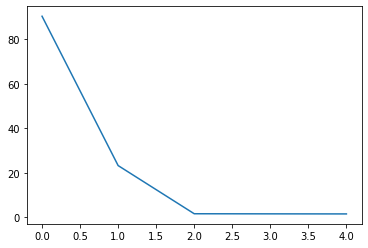

Epoch 1/50
6/6 - 3s - loss: 167.5425 - accuracy: 0.3146 - auc_7: 0.5757 - val_loss: 110.2630 - val_accuracy: 0.5618 - val_auc_7: 0.7261 - 3s/epoch - 454ms/step
Epoch 2/50
6/6 - 1s - loss: 83.6030 - accuracy: 0.4101 - auc_7: 0.6327 - val_loss: 22.3138 - val_accuracy: 0.3371 - val_auc_7: 0.6478 - 864ms/epoch - 144ms/step
Epoch 3/50
6/6 - 1s - loss: 9.5481 - accuracy: 0.4719 - auc_7: 0.7011 - val_loss: 1.6658 - val_accuracy: 0.3315 - val_auc_7: 0.6218 - 868ms/epoch - 145ms/step
Epoch 4/50
6/6 - 1s - loss: 1.5583 - accuracy: 0.4410 - auc_7: 0.5634 - val_loss: 1.6497 - val_accuracy: 0.5562 - val_auc_7: 0.5089 - 861ms/epoch - 144ms/step
Epoch 5/50
6/6 - 1s - loss: 1.6020 - accuracy: 0.5506 - auc_7: 0.6686 - val_loss: 1.6594 - val_accuracy: 0.5449 - val_auc_7: 0.6872 - 870ms/epoch - 145ms/step
Epoch 6/50
6/6 - 1s - loss: 1.6034 - accuracy: 0.5506 - auc_7: 0.7176 - val_loss: 1.6624 - val_accuracy: 0.5449 - val_auc_7: 0.6850 - 879ms/epoch - 146ms/step


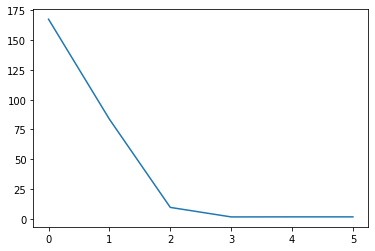

In [15]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    early_fusion_model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [16]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.7028


### 1.2 Early fusion - Pain level prediction

#### Concatenate datasets (fusion stage)

In [17]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_level', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 48) (534, 3)
(81, 1, 350, 48) (81, 3)


#### Train CNN+LSTM Model (from uni-modal architectures)

In [18]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [19]:
early_fusion_model = get_CNN_model(n_features, n_outputs, n_length)
early_fusion_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 348, 64)    9280      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                      

Epoch 1/50
6/6 - 2s - loss: 0.8511 - accuracy: 0.5646 - auc_9: 0.7803 - val_loss: 0.7637 - val_accuracy: 0.6629 - val_auc_9: 0.8163 - 2s/epoch - 365ms/step
Epoch 2/50
6/6 - 0s - loss: 0.7591 - accuracy: 0.6320 - auc_9: 0.8054 - val_loss: 0.7536 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 332ms/epoch - 55ms/step
Epoch 3/50
6/6 - 0s - loss: 0.7388 - accuracy: 0.6320 - auc_9: 0.8074 - val_loss: 0.7385 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 384ms/epoch - 64ms/step
Epoch 4/50
6/6 - 0s - loss: 0.7289 - accuracy: 0.6320 - auc_9: 0.8078 - val_loss: 0.7364 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 361ms/epoch - 60ms/step
Epoch 5/50
6/6 - 0s - loss: 0.7242 - accuracy: 0.6320 - auc_9: 0.8053 - val_loss: 0.7371 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 333ms/epoch - 55ms/step
Epoch 6/50
6/6 - 0s - loss: 0.7216 - accuracy: 0.6320 - auc_9: 0.8100 - val_loss: 0.7382 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 339ms/epoch - 56ms/step


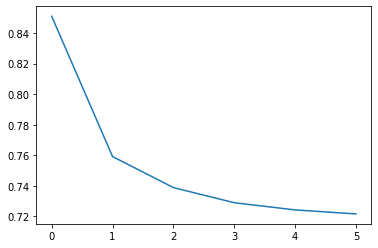

Epoch 1/50
6/6 - 3s - loss: 0.9443 - accuracy: 0.5787 - auc_10: 0.7402 - val_loss: 0.8248 - val_accuracy: 0.6292 - val_auc_10: 0.8108 - 3s/epoch - 425ms/step
Epoch 2/50
6/6 - 0s - loss: 0.8053 - accuracy: 0.6489 - auc_10: 0.8076 - val_loss: 0.7763 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 336ms/epoch - 56ms/step
Epoch 3/50
6/6 - 0s - loss: 0.7963 - accuracy: 0.6489 - auc_10: 0.7957 - val_loss: 0.7979 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 334ms/epoch - 56ms/step
Epoch 4/50
6/6 - 0s - loss: 0.7945 - accuracy: 0.6489 - auc_10: 0.8143 - val_loss: 0.7770 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 335ms/epoch - 56ms/step


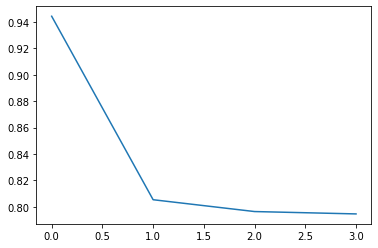

Epoch 1/50
6/6 - 2s - loss: 1.0774 - accuracy: 0.3062 - auc_11: 0.5711 - val_loss: 0.9833 - val_accuracy: 0.6236 - val_auc_11: 0.7329 - 2s/epoch - 365ms/step
Epoch 2/50
6/6 - 0s - loss: 0.9391 - accuracy: 0.6461 - auc_11: 0.8051 - val_loss: 0.8847 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 338ms/epoch - 56ms/step
Epoch 3/50
6/6 - 0s - loss: 0.8562 - accuracy: 0.6461 - auc_11: 0.8200 - val_loss: 0.8377 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 337ms/epoch - 56ms/step
Epoch 4/50
6/6 - 0s - loss: 0.8177 - accuracy: 0.6461 - auc_11: 0.8011 - val_loss: 0.8134 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 336ms/epoch - 56ms/step
Epoch 5/50
6/6 - 0s - loss: 0.7952 - accuracy: 0.6461 - auc_11: 0.8173 - val_loss: 0.8000 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 340ms/epoch - 57ms/step
Epoch 6/50
6/6 - 0s - loss: 0.7829 - accuracy: 0.6461 - auc_11: 0.8154 - val_loss: 0.7913 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 344ms/epoch - 57ms/step
Epoch 7/50
6/6 - 0s - loss: 0.7749 - accur

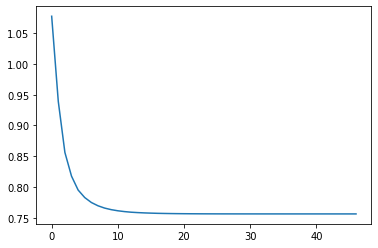

In [20]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    early_fusion_model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [21]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 77.778%

AUC: 0.8704


#### Train Convolutional LSTM Model (from uni-modal architectures)

In [22]:
X_train, X_test, y_train, y_test = apply_early_fusion('processed', 'pain_level', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 1, 350, 48) (534, 3)
(81, 1, 1, 350, 48) (81, 3)


In [23]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [24]:
early_fusion_model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
early_fusion_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 1, 348, 64)        86272     
                                                                 
 flatten_12 (Flatten)        (None, 22272)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2227300   
                                                                 
 dense_25 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,313,875
Trainable params: 2,313,875
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
6/6 - 3s - loss: 270.9732 - accuracy: 0.4579 - auc_13: 0.5970 - val_loss: 15.0294 - val_accuracy: 0.6629 - val_auc_13: 0.7472 - 3s/epoch - 454ms/step
Epoch 2/50
6/6 - 1s - loss: 8.6945 - accuracy: 0.4691 - auc_13: 0.6134 - val_loss: 4.1094 - val_accuracy: 0.6629 - val_auc_13: 0.7472 - 867ms/epoch - 144ms/step
Epoch 3/50
6/6 - 1s - loss: 5.3281 - accuracy: 0.6320 - auc_13: 0.7240 - val_loss: 3.2908 - val_accuracy: 0.6629 - val_auc_13: 0.7440 - 868ms/epoch - 145ms/step
Epoch 4/50
6/6 - 1s - loss: 2.3285 - accuracy: 0.5309 - auc_13: 0.7418 - val_loss: 1.5722 - val_accuracy: 0.5337 - val_auc_13: 0.7622 - 858ms/epoch - 143ms/step
Epoch 5/50
6/6 - 1s - loss: 1.8314 - accuracy: 0.6180 - auc_13: 0.8034 - val_loss: 1.5612 - val_accuracy: 0.5787 - val_auc_13: 0.8136 - 870ms/epoch - 145ms/step
Epoch 6/50
6/6 - 1s - loss: 1.6406 - accuracy: 0.4663 - auc_13: 0.7210 - val_loss: 1.4572 - val_accuracy: 0.5449 - val_auc_13: 0.7904 - 862ms/epoch - 144ms/step
Epoch 7/50
6/6 - 1s - loss: 1.4564

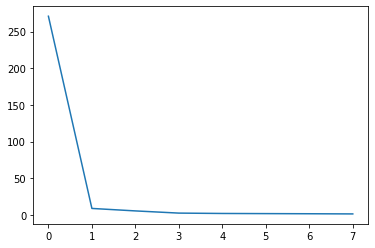

Epoch 1/50
6/6 - 3s - loss: 86.4325 - accuracy: 0.5169 - auc_14: 0.6477 - val_loss: 3.8345 - val_accuracy: 0.1404 - val_auc_14: 0.5275 - 3s/epoch - 450ms/step
Epoch 2/50
6/6 - 1s - loss: 1.5525 - accuracy: 0.5562 - auc_14: 0.5542 - val_loss: 1.1084 - val_accuracy: 0.6292 - val_auc_14: 0.7431 - 863ms/epoch - 144ms/step
Epoch 3/50
6/6 - 1s - loss: 1.0981 - accuracy: 0.6461 - auc_14: 0.7887 - val_loss: 1.0905 - val_accuracy: 0.6292 - val_auc_14: 0.8083 - 847ms/epoch - 141ms/step
Epoch 4/50
6/6 - 1s - loss: 1.0876 - accuracy: 0.6461 - auc_14: 0.8064 - val_loss: 1.0796 - val_accuracy: 0.6292 - val_auc_14: 0.8083 - 854ms/epoch - 142ms/step
Epoch 5/50
6/6 - 1s - loss: 1.0811 - accuracy: 0.6461 - auc_14: 0.8081 - val_loss: 1.0736 - val_accuracy: 0.6292 - val_auc_14: 0.8134 - 848ms/epoch - 141ms/step
Epoch 6/50
6/6 - 1s - loss: 1.0762 - accuracy: 0.6461 - auc_14: 0.8095 - val_loss: 1.0695 - val_accuracy: 0.6292 - val_auc_14: 0.8139 - 849ms/epoch - 142ms/step
Epoch 7/50
6/6 - 1s - loss: 1.0722 -

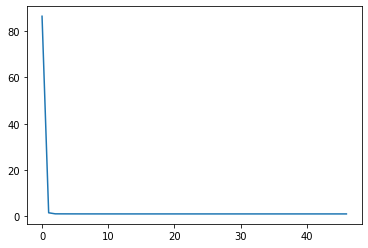

Epoch 1/50
6/6 - 3s - loss: 155.0260 - accuracy: 0.4579 - auc_15: 0.5955 - val_loss: 321.4475 - val_accuracy: 0.6348 - val_auc_15: 0.7261 - 3s/epoch - 458ms/step
Epoch 2/50
6/6 - 1s - loss: 176.7121 - accuracy: 0.5843 - auc_15: 0.6895 - val_loss: 77.0414 - val_accuracy: 0.4045 - val_auc_15: 0.5628 - 876ms/epoch - 146ms/step
Epoch 3/50
6/6 - 1s - loss: 44.8347 - accuracy: 0.5562 - auc_15: 0.6721 - val_loss: 33.3530 - val_accuracy: 0.6348 - val_auc_15: 0.7241 - 880ms/epoch - 147ms/step
Epoch 4/50
6/6 - 1s - loss: 16.8644 - accuracy: 0.5253 - auc_15: 0.6815 - val_loss: 11.5606 - val_accuracy: 0.4270 - val_auc_15: 0.6195 - 872ms/epoch - 145ms/step
Epoch 5/50
6/6 - 1s - loss: 8.5888 - accuracy: 0.5590 - auc_15: 0.7202 - val_loss: 8.2119 - val_accuracy: 0.5899 - val_auc_15: 0.7326 - 867ms/epoch - 144ms/step
Epoch 6/50
6/6 - 1s - loss: 5.7266 - accuracy: 0.6236 - auc_15: 0.7819 - val_loss: 3.9932 - val_accuracy: 0.5393 - val_auc_15: 0.7230 - 864ms/epoch - 144ms/step
Epoch 7/50
6/6 - 1s - loss

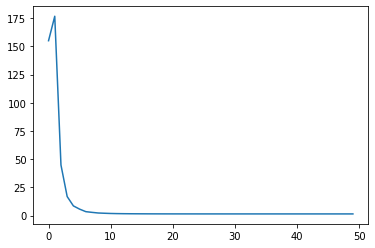

In [25]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    early_fusion_model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(early_fusion_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

In [26]:
loss, accuracy, auc = early_fusion_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 59.259%

AUC: 0.7659


### 1.3 Late fusion - Pain area prediction

### 1.4 Late fusion - Pain level prediction

## 2. Ensemble

Variants:

-  **Early fusion**: a combination of the content of each ensemble member, for example, its prediction score are aggregated to learn a classifier (i.e., meta-learning).

- **Late fusion**: 

## 3. Results

In [27]:
def show_results(first, last):
    plt.rcParams['figure.figsize'] = (8,8)
    x = np.arange(len(model_names[first:last]))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies[first:last], width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs[first:last], width, label='AUC * 100')

    ax.set_ylim(0, 100)
    ax.set_xticks(x, model_names[first:last])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

### Model-free Early fusion - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

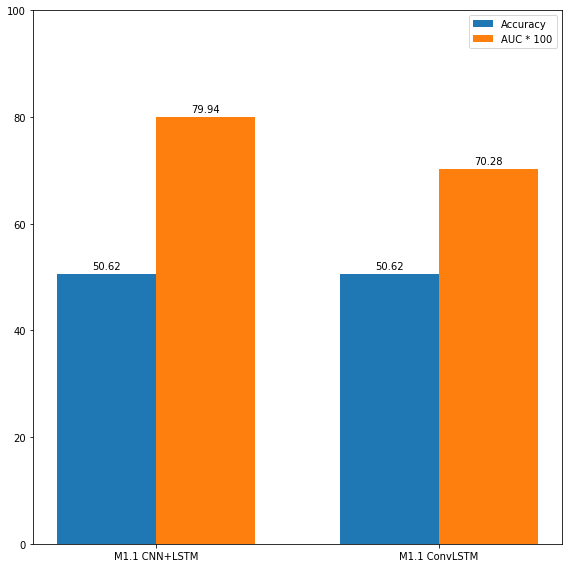

In [28]:
show_results(0, 2)

### Model-free Early fusion - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

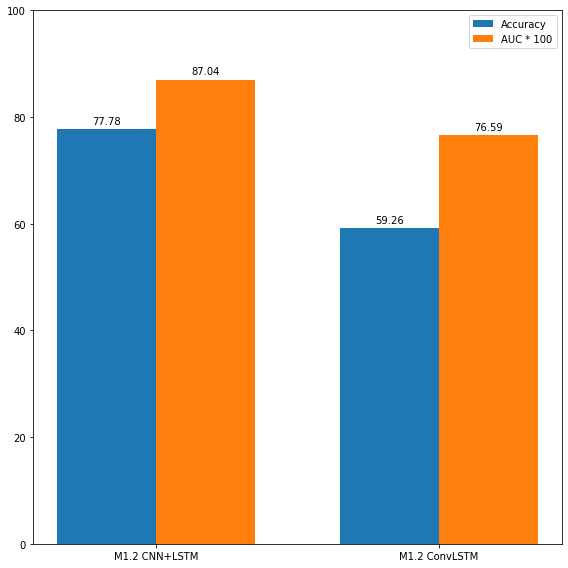

In [29]:
show_results(2, 4)